# PCA Exercises - Core
**Student:** Matthew Malueg

### Loading, Imports, Custom Functions

In [1]:
# Imports
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classifiication report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = '-'*70
  print(header, f'Classification Metrics: {label}', header, sep='\n')
  print(report)
  ## CONFUSION MATRICIES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # Create a confusion matrix of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          normalize=None, cmap='gist_gray',
                                          colorbar=colorbar,
                                          ax = axes[0],)
  axes[0].set_title('Raw Counts')
  # Create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          normalize=normalize, cmap=cmap,
                                          colorbar=colorbar,
                                          ax = axes[1],)
  axes[1].set_title('Normalized Confusion Matrix')
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict=False,
                            cmap_train='Blues', cmap_test='Reds',
                            colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, output_dict=True,
                                         figsize=figsize, colorbar=colorbar,
                                         cmap=cmap_train, label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, output_dict=True,
                                        figsize=figsize, colorbar=colorbar,
                                        cmap=cmap_test, label='Test Data')
  if output_dict==True:
    # Store results in a dataframe if output_dict is True
    results_dict = {'train': results_train,
                    'test':  results_test}
    return results_dict

In [3]:
# Load the dataset
df = pd.read_csv("Data/NHANES_Diet_Diabetes_Risk.xls.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6643 entries, 0 to 6642
Columns: 169 entries, SEQN to Diabetes_Risk
dtypes: float64(166), int64(3)
memory usage: 8.6 MB


,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.0,738.0,863.0,0.0,1476.0,0.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
4,73562,49890.82866,0.00000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.0,272.0,355.0,172.0,776.0,300.0,2339.0,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0


In [4]:
# This column is empty and was found when it gave an error during the TTS step
df = df.drop(columns=['DRQSDT5'])

### Preprocess the data

In [5]:
df.set_index('SEQN')

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.890650,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.00,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.148870,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.00,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.236710,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.00,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73561,59052.35703,39004.892990,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.00,738.0,863.0,0.0,1476.0,0.0,0.0,0.0,1.484,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
73562,49890.82866,0.000000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.00,272.0,355.0,172.0,776.0,300.0,2339.0,2101.0,1.227,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83721,50162.97146,35482.349600,1,49.0,2.0,2.0,6.0,1.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1225.0,35.05,250.82,127.22,30.7,17.97,4.087,4.981,6.438,6.0,5.19,0.00,1072.0,1780.0,2619.0,7077.0,202.0,0.0,1909.0,2.804,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,N

In [6]:
# Train Test Split
y = df['Diabetes_Risk']
X = df.drop(columns=['Diabetes_Risk']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
## Make pipeline to impute missing values and scale data
# Select numeric columns
num_cols = X_train.select_dtypes('number').columns
# Instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make pieple and transformer
num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)
col_transformer = ColumnTransformer([num_tuple], verbose_feature_names_out=False)

In [1]:
"""
Remove this, the data is being transformed twice. Here and inside the KNN pipeline
"""

# Fit the ColumnTransformer on X_train
col_transformer.fit(X_train)
# Transform X_train and X_test
X_train_tf = col_transformer.transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

NameError: name 'col_transformer' is not defined

### Model - No PCA

In [9]:
## Fit a default KNN model to the data
# Define KNN model
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(col_transformer, knn)

In [10]:
# Fit the default KNN model
knn_pipe.fit(X_train_tf, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['SEQN', 'WTDRD1', 'WTDR2D', 'DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT',
       'DR1DBIH', 'DR1DAY', 'DR1LANG',
       ...
       'DRD370QQ', 'DRD370R', 'DRD370RQ', 'DRD370S', 'DRD370SQ', 'DRD370T',
       'DRD370TQ', 'DRD370U', 'DRD370UQ', 'DRD370V'],
      dtype='object', length=167))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [11]:
%%time
# Display time it takes to run predictions
def_preds = knn_pipe.predict(X_test_tf)

CPU times: total: 1.41 s
Wall time: 154 ms


----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4080
           1       0.00      0.00      0.00       446
           2       0.00      0.00      0.00       456

    accuracy                           0.82      4982
   macro avg       0.27      0.33      0.30      4982
weighted avg       0.67      0.82      0.74      4982



C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


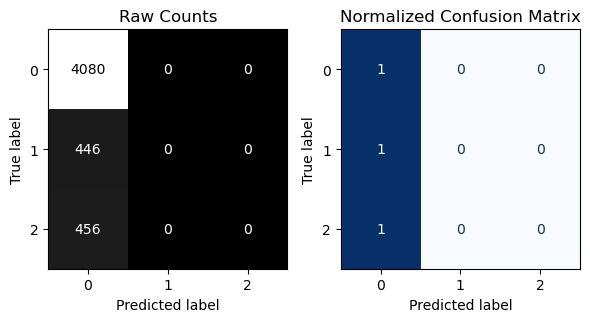

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



----------------------------------------------------------------------
Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1372
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00       148

    accuracy                           0.83      1661
   macro avg       0.28      0.33      0.30      1661
weighted avg       0.68      0.83      0.75      1661



C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


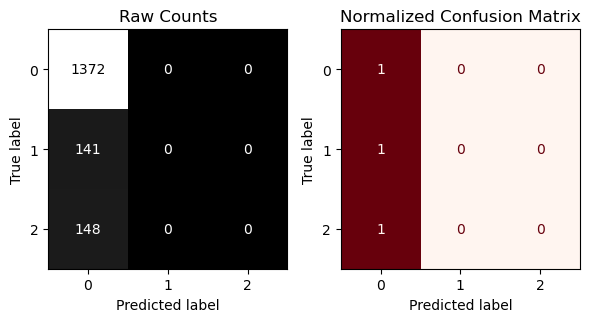

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Evaluate the model using appropriate metrics
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

### Transform the data with PCA

In [13]:
# First, initialize and fit PCA
pca = PCA()
pca.fit(X_train_tf, y_train)

PCA()

In [14]:
# Transform the data to keep 95% variance
pca95 = PCA(n_components=0.95)
# Fit and transform on training data
X_train_pca95 = pca95.fit_transform(X_train_tf)
# Transform test data
X_test_pca95 = pca95.transform(X_test_tf)

In [15]:
# Check how many PCs were created
pca95.n_components_

100

- There were a total of 99 principal components created.

### Model - With PCA

In [16]:
# Fit a default KNN model onto the PCA transformed data
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_train_pca95, y_train)

KNeighborsClassifier()

In [17]:
%%time
# Record the time it takes to run predictions
preds_pca = knn_pca.predict(X_test_pca95)

CPU times: total: 719 ms
Wall time: 112 ms


----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      4080
           1       0.65      0.07      0.13       446
           2       0.56      0.07      0.12       456

    accuracy                           0.83      4982
   macro avg       0.68      0.38      0.39      4982
weighted avg       0.79      0.83      0.76      4982



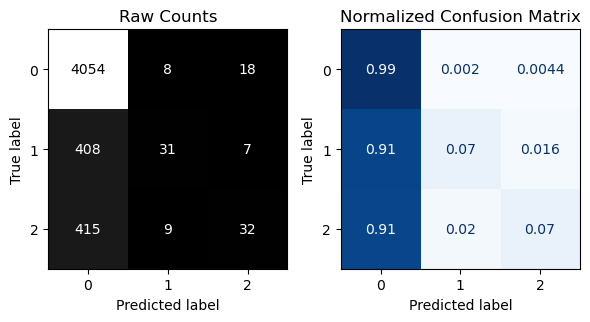


----------------------------------------------------------------------
Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1372
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00       148

    accuracy                           0.81      1661
   macro avg       0.27      0.33      0.30      1661
weighted avg       0.68      0.81      0.74      1661



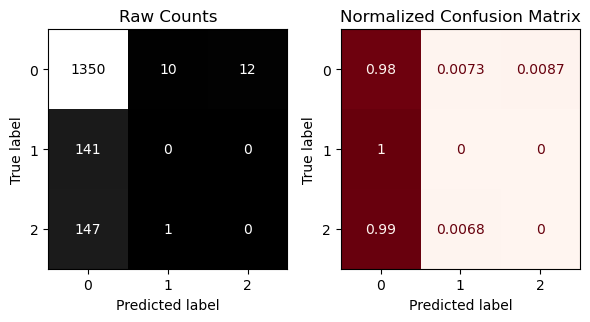

In [18]:
# Evaluate the model using appropriate metrics
evaluate_classification(knn_pca, X_train_pca95, y_train, X_test_pca95, y_test)

### Compare the models

1. How many features were in the first model, and how many PCs were used in the PCA model?
    - The original model was working with 167 features, while the PCA model only had 100 PCs.
2. Which model performed the best on the test set?
    - Both models had the same f1-score on test data, and accuracy/weighted avg/macro avg were within a percentage point or two.
3. Which model was the fastest at making predictions?
    - The PCA model had about 4 times faster CPU times for running predictions.